<a href="https://colab.research.google.com/github/nguyenhaidang94/CustomerReviewAnalysis/blob/master/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import os
import re
import numpy.random as npr

import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Clone repo and install packages

In [0]:
!git clone https://github.com/deepai-solutions/core_nlp.git
!pip install python-crfsuite
!pip install sklearn_crfsuite

Cloning into 'core_nlp'...
remote: Enumerating objects: 205, done.
remote: Total 205 (delta 0), reused 0 (delta 0), pack-reused 205
Receiving objects: 100% (205/205), 9.69 MiB | 26.33 MiB/s, done.
Resolving deltas: 100% (101/101), done.
     |████████████████████████████████| 757kB 3.5MB/s 


## Define PATH

In [0]:
#@title
folder_path = "/content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dataset/labeled_data"
train_folder = "data_train/train"
val_folder = "data_train/test"
test_folder = "data_test/test"
pos_folder = "pos"
neg_folder = "neg"
separator = "/"

def get_folder_path():
  return folder_path

def get_separator():
  return separator

def get_test_pos_folder(separator = "/"):
  paths = [folder_path, test_folder, pos_folder]
  return separator.join(paths)

def get_test_neg_folder(separator = "/"):
  paths = [folder_path, test_folder, neg_folder]
  return separator.join(paths)

def get_train_pos_folder(separator = "/"):
  paths = [folder_path, train_folder, pos_folder]
  return separator.join(paths)

def get_train_neg_folder(separator = "/"):
  paths = [folder_path, train_folder, neg_folder]
  return separator.join(paths)

def get_val_pos_folder(separator = "/"):
  paths = [folder_path, val_folder, pos_folder]
  return separator.join(paths)

def get_val_neg_folder(separator = "/"):
  paths = [folder_path, val_folder, neg_folder]
  return separator.join(paths)

## Function read file content

In [0]:
def read_file_content(path):
  with open(path, 'r') as f:
    return f.read()

def read_files(path):
  file_contents = []
  with os.scandir(path) as entries:
    for entry in entries:
      if entry.is_file():
        file_content = read_file_content(entry.path)
        file_contents.append(file_content)
  return file_contents

## Function save data to pickle

In [0]:
def save_reviews_to_pickle(pos_folder, neg_folder, save_path):
  pos_reviews = read_files(pos_folder)
  pos_labels = np.ones(len(pos_reviews))
  neg_reviews = read_files(neg_folder)
  neg_labels = np.zeros(len(neg_reviews))
  
  reviews = np.concatenate((pos_reviews, neg_reviews))
  labels = np.concatenate((pos_labels, neg_labels))
  
  data = pd.DataFrame()
  data[review_col] = reviews
  data[label_col] = labels
  # Shuffle dataframe
  data = data.sample(frac=1).reset_index(drop=True)
  
  data.to_pickle(save_path)

## Process saving data to pickle

In [0]:
# Save training data to pickle
# save_reviews_to_pickle(get_train_pos_folder(), get_train_neg_folder()
#                        , get_folder_path() + get_separator() + saved_train_file)

# Save validation data to pickle
# save_reviews_to_pickle(get_val_pos_folder(), get_val_neg_folder()
#                        , get_folder_path() + get_separator() + saved_val_file)

# Save testing data to pickle
# save_reviews_to_pickle(get_test_pos_folder(), get_test_neg_folder()
#                        , get_folder_path() + get_separator() + saved_test_file)

## Preprocessing

### Function for preprocessing

In [0]:
# Remove false mark and not having mark reviews

false_mark = ' ́'[1] + ' ̀'[1] + ' ̉'[1] + ' ̣'[1] + ' ̃'[1]
vietnam_alp = 'áàãảạăắằẳẵặâấầẩẫậóòỏõọôốồổộỗơớờởỡợúùủũụưứừữựửíìỉĩịýỳỷỹỵéèẻẽẹêếềểễệ'


def is_false_mark(string):
  """
    True if string is false mark. 
  """
  return (any ( c in false_mark for c in string))
    
  
def is_have_mark(string):
  """
    False if string is not have mark 
  """
  return (any ( c in vietnam_alp for c in string))

def find_false_mark(df, col):
  false_mark_indices = []
  for index, row in df.iterrows():
    if is_false_mark(row[col].lower()):
      false_mark_indices.append(index)
  return false_mark_indices

def find_not_having_mark(df, col):
  not_have_mark_indices = []
  for index, row in df.iterrows():
    if not is_have_mark(row[col].lower()):
      not_have_mark_indices.append(index)
  return not_have_mark_indices

def remove_not_having_mark(df, col_name):
  not_have_mark_indices = find_not_having_mark(df, col_name)
  print("Don't have mark: {}, take {}%".format(len(not_have_mark_indices)
                                             , len(not_have_mark_indices)/len(df) * 100))
  df.drop(index=not_have_mark_indices, inplace=True)
  df.reset_index(drop=True, inplace=True)

In [0]:
magic_re = r'(?P<mark>[áàãảạắằẳẵặấầẩẫậóòỏõọốồổộỗớờởỡợúùủũụứừữựửíìỉĩịýỳỷỹỵéèẻẽẹếềểễệ]) (?P<word>([a-z][a-z][_.,;!?]* )|([a-z][_.,;!?]* )|([a-z][a-z][.,;!?])|([a-z][[.,;!?]]))'

def correct_false_mark(string):
  """ 
    Correct False Mark
  """
  
  string =  re.sub('a ́','á',string)  
  string =  re.sub('a ̀','à',string)  
  string =  re.sub('a ̉','ả',string)
  string =  re.sub('a ̣','ạ',string)  
  string =  re.sub('a ̃','ã',string) 
  
  string =  re.sub('ă ́','ắ',string)  
  string =  re.sub('ă ̀','ằ',string)  
  string =  re.sub('ă ̉','ẳ',string)
  string =  re.sub('ă ̣','ặ',string)  
  string =  re.sub('ă ̃','ẵ',string)  
  
  string =  re.sub('â ́','ấ',string)  
  string =  re.sub('â ̀','ầ',string)  
  string =  re.sub('â ̉','ậ',string)
  string =  re.sub('â ̃','ẫ',string)  
  string =  re.sub('â ̣','ậ',string)  
  
  string =  re.sub('o ́','ó',string)  
  string =  re.sub('o ̀','ò',string)  
  string =  re.sub('o ̉','ỏ',string)
  string =  re.sub('o ̃','õ',string)  
  string =  re.sub('o ̣','ọ',string)  
  
  string =  re.sub('ô ́','ố',string)  
  string =  re.sub('ô ̀','ồ',string)  
  string =  re.sub('ô ̉','ổ',string)
  string =  re.sub('ô ̃','ỗ',string)  
  string =  re.sub('ô ̣','ộ',string)
  
  string =  re.sub('ơ ́','ớ',string)  
  string =  re.sub('ơ ̀','ờ',string)  
  string =  re.sub('ơ ̉','ở',string)
  string =  re.sub('ơ ̃','ỡ',string)  
  string =  re.sub('ơ ̣','ợ',string)

  string =  re.sub('u ́','ú',string)  
  string =  re.sub('u ̀','ù',string)  
  string =  re.sub('u ̉','ủ',string)
  string =  re.sub('u ̃','ũ',string)  
  string =  re.sub('u ̣','ụ',string)
  
  string =  re.sub('ư ́','ứ',string)  
  string =  re.sub('ư ̀','ừ',string)  
  string =  re.sub('ư ̉','ử',string)
  string =  re.sub('ư ̃','ữ',string)  
  string =  re.sub('ư ̣','ự',string)
  
  string =  re.sub('i ́','í',string)  
  string =  re.sub('i ̀','ì',string)  
  string =  re.sub('i ̉','ỉ',string)
  string =  re.sub('i ̃','ĩ',string)  
  string =  re.sub('i ̣','ị',string)
  
  string =  re.sub('y ́','ý',string)  
  string =  re.sub('y ̀','ỳ',string)  
  string =  re.sub('y ̉','ỷ',string)
  string =  re.sub('y ̃','ỹ',string)  
  string =  re.sub('y ̣','ỵ',string)
  
  string =  re.sub('e ́','é',string)  
  string =  re.sub('e ̀','è',string)  
  string =  re.sub('e ̉','ẻ',string)
  string =  re.sub('e ̃','ẽ',string)  
  string =  re.sub('e ̣','ẹ',string)
  
  string =  re.sub('ê ́','ế',string)  
  string =  re.sub('ê ̀','ề',string)  
  string =  re.sub('ê ̉','ể',string)
  string =  re.sub('ê ̃','ễ',string)  
  string =  re.sub('ê ̣','ệ',string)
  
  string = re.sub(magic_re,'\g<mark>\g<word> ', string)
  return string

def recompile_false_mark(df, col_name):
  false_mark_indices = find_false_mark(df, col_name)
  print("False mark: {}, take {}%".format(len(false_mark_indices)
                                             , len(false_mark_indices)/len(df) * 100))
  print("Recompile false mark")
  df.loc[false_mark_indices, col_name] = df.loc[false_mark_indices, col_name].apply(correct_false_mark)
  
  new_false_mark_indices = find_false_mark(df, col_name)
  print("Remaining false mark: {}, take {}%".format(len(new_false_mark_indices)
                                                    , len(new_false_mark_indices)/len(df) * 100))

In [0]:
# Remove new line, comma, special chars, numbers, special words
special_chars_re = "[+\-\"():;\\\/\^<>']"
numbers_re = "\d+"

# TODO: some reviews, user starts new line without dot
def remove_new_line(str):
  return str.replace("\n", "")

def remove_comma(str):
  return str.replace(",", "")

def replace_underline(str):
  return str.replace("_", " ")

def remove_sepcial_chars(str):
  return re.sub(special_chars_re, "", str)

def remove_numbers(str):
  return re.sub(numbers_re, "", str)

def remove_special_word(str, special_word):
  return str.replace(special_word, "")

In [0]:
# Remove stop words
def read_file_content(path):
  with open(path, 'r') as f:
    return f.read()

def remove_stop_words(str, stop_words):
  words = str.split()
  result_words  = [word for word in words if word not in stop_words]
  return ' '.join(result_words)

In [0]:
# Lower case
def lower_case(str):
  return str.lower()

In [0]:
# Combine words using gensim Phrases
def combine_words(review, bigram_model):
  words = review.split()
  new_review = " ".join(bigram_model[words])
  return new_review

In [0]:
# Tokenize
def tokenize(list_str, tokenizer):
  list_tokens = []
  for str in list_str:
    list_tokens.append(tokenizer.tokenize(str))
  return list_tokens

### Combine to one step

In [0]:
# Combine all steps together
origin_review_col = "review"
review_col = "review_cleaned"
bigram_model_file = "/content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dang/lda/bigram.dat"
file_stop_words = "/content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/vietnamese-stopwords.txt"

def preprocessing(df):
  df[review_col] = df[origin_review_col].values
  print("Remove not having mark reviews...")
  remove_not_having_mark(df, review_col)
  print("Number of remaining reviews: {}".format(len(df)))
  print("Recompile false mark")
  recompile_false_mark(df, review_col)
  
  print("Remove new line...")
  df[review_col] = df[review_col].apply(remove_new_line)
  print("Remove comma...")
  df[review_col] = df[review_col].apply(remove_comma)
  print("Remove special chars...")
  df[review_col] = df[review_col].apply(remove_sepcial_chars)
  print("Remove numbers...")
  df[review_col] = df[review_col].apply(remove_numbers)
  print("Lower case...")
  df[review_col] = df[review_col].apply(lower_case)
  
#   print("Load bigram model...")
#   bigram = Phrases.load(bigram_model_file)
#   print("Combine words...")
#   df[review_col] = df[review_col].apply(combine_words, args=(bigram,))
  
  print("Remove stop words...")
  full_stop_words = read_file_content(file_stop_words)
  list_stop_words = full_stop_words.split("\n")
  df[review_col] = df[review_col].apply(remove_stop_words, args=(list_stop_words,))
  print("Finished preprocessing!")

## Load data

In [0]:
# training_data = pd.read_pickle(get_folder_path() + get_separator() + saved_train_file)
# preprocessing(training_data)

# validation_data = pd.read_pickle(get_folder_path() + get_separator() + saved_val_file)
# preprocessing(validation_data)

# testing_data = pd.read_pickle(get_folder_path() + get_separator() + saved_test_file)
# preprocessing(testing_data)

In [0]:
training_cleaned_file = "training_cleaned.pkl"
validation_cleaned_file = "validation_cleaned.pkl"
testing_cleaned_file = "testing_cleaned.pkl"

# training_data.to_pickle(folder_path + get_separator() + training_cleaned_file)
# validation_data.to_pickle(folder_path + get_separator() + validation_cleaned_file)
# testing_data.to_pickle(folder_path + get_separator() + testing_cleaned_file)

training_data = pd.read_pickle(get_folder_path() + get_separator() + training_cleaned_file)
testing_data = pd.read_pickle(get_folder_path() + get_separator() + testing_cleaned_file)
validation_data = pd.read_pickle(get_folder_path() + get_separator() + validation_cleaned_file)

## Common code

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from core_nlp.tokenization.crf_tokenizer import CrfTokenizer

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.utils.vis_utils import plot_model

from gensim.corpora import Dictionary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.phrases import Phrases, Phraser

Using TensorFlow backend.


In [0]:
# Global variables
w2v_file = "/content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dang/word2vec.dat"
unlabeled_w2v_file = "/content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dang/word2vec_unlabeled.dat"
review_col = "review_cleaned"
label_col = "label"
saved_train_file = "training.pkl"
saved_val_file = "validation.pkl"
saved_test_file = "testting.pkl"

def sample(low, high, n_samples):
  return npr.randint(low, high, n_samples)

def train_countvectorizer(sentences, tokenizer=None):
  vectorizer = CountVectorizer(analyzer="word", tokenizer=tokenizer)
  vectorizer.fit(sentences)
  return vectorizer

def train_tfidfvectorizer(sentences, tokenizer=None):
  vectorizer = TfidfVectorizer(analyzer="word", tokenizer=tokenizer)
  vectorizer.fit(sentences)
  return vectorizer

def get_tokenizer():
  tokenizer = CrfTokenizer(config_root_path='core_nlp/tokenization/',
                          model_path='core_nlp/models/pretrained_tokenizer.crfsuite')
  return tokenizer

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(20, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  
def tokenize_sentences(list_sentences, tokenizer):
  list_tokens = []
  for sentence in list_sentences:
    list_tokens.append(tokenizer.tokenize(sentence))
  return list_tokens

def find_max_len_in_matrix(matrix_x, current_max_len=0):
  max_len = current_max_len
  for i in range(0, len(matrix_x)):
    length = len(matrix_x[i])
    if length > max_len:
      max_len = length
  return max_len

def find_max_len_in_matrices(matrix_x, matrix_y, matrix_z):
  max_len = find_max_len_in_matrix(matrix_x)
  max_len = find_max_len_in_matrix(matrix_y, max_len)
  max_len = find_max_len_in_matrix(matrix_z, max_len)
  return max_len

def evaluate_nn(model, X_train, y_train, X_val, y_val, X_test, y_test):
  training_loss, training_accuracy = model.evaluate(X_train, y_train, verbose=False)
  print("Training Accuracy:  {:.4f}".format(training_accuracy))
  
  val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=False)
  print("Validation Accuracy:  {:.4f}".format(val_accuracy))
  
  testing_loss, testing_accuracy = model.evaluate(X_test, y_test, verbose=False)
  print("Testing Accuracy:  {:.4f}".format(testing_accuracy))

def train_word2vec(list_tokens, vector_dim, saved_file):
  print("Training word2vec...")
  word2vec_model = Word2Vec(list_tokens, size=vector_dim, window=5, min_count=1)
  word_vectors = word2vec_model.wv
  word_vectors.save_word2vec_format(saved_file)
  
def train_word2vec_limit_vocab(list_tokens, vector_dim, max_vocab_size, saved_file):
  print("Training word2vec...")
  word2vec_model = Word2Vec(list_tokens, size=vector_dim, max_final_vocab=max_vocab_size
                            , window=5, min_count=1)
  word_vectors = word2vec_model.wv
  word_vectors.save_word2vec_format(saved_file)
  
def transform_sentences_to_indices(word_vectors, list_tokens):
  list_indicies = []
  for tokens in list_tokens:
    # change to 1-based index
#     indices = [word_vectors.vocab[token].index + 1 for token in tokens]
    indices = []
    for token in tokens:
      index = 0
      try:
        index = word_vectors.vocab[token].index + 1
      except:
        index = 0
      indices.append(index)
    list_indicies.append(indices)
  
  return list_indicies

def transform_tokens_to_indices(word_vectors, tokens):
  indices = []
  for token in tokens:
    index = 0
    try:
      index = word_vectors.vocab[token].index + 1
    except:
      index = 0
    indices.append(index)
  return indices

## Baseline model

In [0]:
def run_baseline_model(classifier, training_data, validation_data, testing_data):
  print("Building Vectorizer...")
  reviews = np.concatenate((training_data[review_col].values
                            , validation_data[review_col].values, testing_data[review_col].values))
  tokenizer = get_tokenizer()
  vectorizer = train_tfidfvectorizer(reviews, tokenizer.tokenize)
  X_train = vectorizer.transform(training_data[review_col].values)
  y_train = training_data[label_col].values

  X_val = vectorizer.transform(validation_data[review_col].values)
  y_val = validation_data[label_col].values

  X_test = vectorizer.transform(testing_data[review_col].values)
  y_test = testing_data[label_col].values

  print("Training baseline model...")
  classifier.fit(X_train, y_train)

  training_score = classifier.score(X_train, y_train)
  print("Score in training set: {}".format(training_score))
  
  val_score = classifier.score(X_val, y_val)
  print("Score in validation set: {}".format(val_score))

  test_score = classifier.score(X_test, y_test)
  print("Score in testing set: {}".format(test_score))
  return vectorizer

In [0]:
print("Running Logistic baseline model...")
lr_classifier = LogisticRegression()
vectorizer = run_baseline_model(lr_classifier, training_data
                                            , validation_data, testing_data)

Running baseline model...
Building Vectorizer...
Loading model from file core_nlp/models/pretrained_tokenizer.crfsuite
Training baseline model...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score in training set: 0.910539050947708
Score in validation set: 0.8758308157099698
Score in testing set: 0.8824418253248716


BOW:
* Score in training set: 0.9568490388493077
* Score in validation set: 0.8696878147029204
* Score in testing set: 0.8757932910244787

TFIDF:
* Score in training set: 0.910539050947708
* Score in validation set: 0.8758308157099698
* Score in testing set: 0.8824418253248716


## Neural Network with BOW

In [0]:
def build_simple_NN(n_features):
  model = Sequential()
  model.add(layers.Dense(10, input_dim=n_features, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

def run_nn_model(training_data, validation_data, testing_data
                 , epochs=10, batch_size=100):
  print("Building Vectorizer...")
  reviews = np.concatenate((training_data[review_col].values
                            , validation_data[review_col].values, testing_data[review_col].values))
  tokenizer = get_tokenizer()
  vectorizer = train_countvectorizer(reviews, tokenizer.tokenize)

  X_train = vectorizer.transform(training_data[review_col].values)
  print("Vocabulary size :{}".format(X_train.shape[1]))
  y_train = training_data[label_col].values

  X_val = vectorizer.transform(validation_data[review_col].values)
  y_val = validation_data[label_col].values

  X_test = vectorizer.transform(testing_data[review_col].values)
  y_test = testing_data[label_col].values
  
  print("Building NN model...")
  model = build_simple_NN(X_train.shape[1])
  model.compile(loss='binary_crossentropy', optimizer='adam'
                    , metrics=['accuracy'])
  print(model.summary())

  print("Training NN model...")
  history = model.fit(X_train, y_train, epochs=epochs
                          , validation_data=(X_val, y_val), batch_size=batch_size)
  plot_history(history)
  
  print("Evaluation...")
  evaluate_nn(model, X_train, y_train, X_val, y_val, X_test, y_test)

def run_nn_model_reduce_size(training_data, validation_data, testing_data
                 , input_dim=400, epochs=10, batch_size=100):
  print("Building Vectorizer...")
  reviews = np.concatenate((training_data[review_col].values
                            , validation_data[review_col].values, testing_data[review_col].values))
  tokenizer = get_tokenizer()
  vectorizer = train_countvectorizer(reviews, tokenizer.tokenize)

  X_train = vectorizer.transform(training_data[review_col].values)
  print("Vocabulary size :{}".format(X_train.shape[1]))
  y_train = training_data[label_col].values

  X_val = vectorizer.transform(validation_data[review_col].values)
  y_val = validation_data[label_col].values

  X_test = vectorizer.transform(testing_data[review_col].values)
  y_test = testing_data[label_col].values
  
  print("Reduce dimension to {}...".format(input_dim))
  lsa = TruncatedSVD(n_components=input_dim)
  X_train = lsa.fit_transform(X_train)
  X_val = lsa.transform(X_val)
  X_test = lsa.transform(X_test)
  
  print("Building NN model...")
  model = build_simple_NN(X_train.shape[1])
  model.compile(loss='binary_crossentropy', optimizer='adam'
                    , metrics=['accuracy'])
  print(model.summary())

  print("Training NN model...")
  history = model.fit(X_train, y_train, epochs=epochs
                          , validation_data=(X_val, y_val), batch_size=batch_size)
  plot_history(history)
  
  print("Evaluation...")
  evaluate_nn(model, X_train, y_train, X_val, y_val, X_test, y_test)

Building Vectorizer...
Loading model from file core_nlp/models/pretrained_tokenizer.crfsuite
Vocabulary size :60537


W0707 10:09:57.806898 139700120360832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0707 10:09:57.835864 139700120360832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0707 10:09:57.843243 139700120360832 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Building NN model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 10)                605380    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 605,391
Trainable params: 605,391
Non-trainable params: 0
_________________________________________________________________
None
Training NN model...


W0707 10:09:58.185780 139700120360832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 29756 samples, validate on 9930 samples
Epoch 1/30
29756/29756 [==============================] - 17s 571us/step - loss: 0.3723 - acc: 0.8624 - val_loss: 0.2984 - val_acc: 0.8840
Epoch 2/30
29756/29756 [==============================] - 13s 439us/step - loss: 0.2468 - acc: 0.9066 - val_loss: 0.2920 - val_acc: 0.8833
Epoch 3/30
29756/29756 [==============================] - 13s 448us/step - loss: 0.2046 - acc: 0.9237 - val_loss: 0.2967 - val_acc: 0.8807
Epoch 4/30
29756/29756 [==============================] - 13s 439us/step - loss: 0.1756 - acc: 0.9363 - val_loss: 0.3096 - val_acc: 0.8714
Epoch 5/30
29756/29756 [==============================] - 13s 438us/step - loss: 0.1531 - acc: 0.9452 - val_loss: 0.3256 - val_acc: 0.8715
Epoch 6/30
29756/29756 [==============================] - 13s 440us/step - loss: 0.1355 - acc: 0.9521 - val_loss: 0.3453 - val_acc: 0.8688
Epoch 7/30
29756/29756 [==============================] - 13s 440us/step - loss: 0.1209 - acc: 0.9575 - val_loss: 0.3

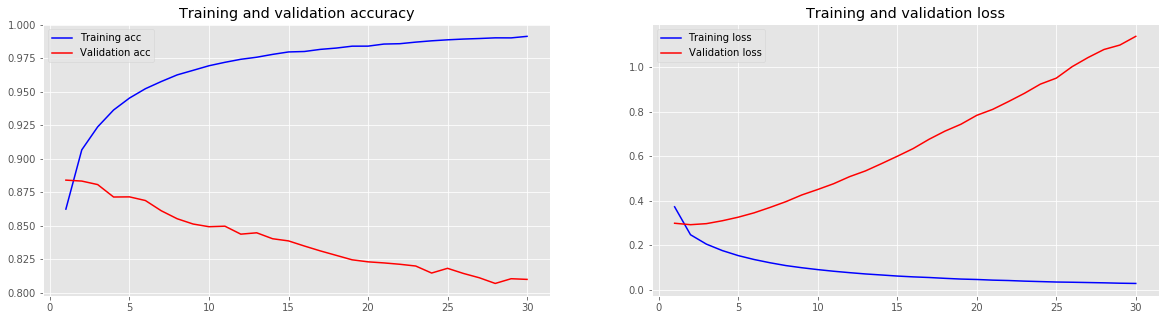

In [0]:
run_nn_model(training_data, validation_data, testing_data, epochs=30)

Building Vectorizer...
Loading model from file core_nlp/models/pretrained_tokenizer.crfsuite
Vocabulary size :51972
Reduce dimension to 400...
Building NN model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                4010      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 4,021
Trainable params: 4,021
Non-trainable params: 0
_________________________________________________________________
None
Training NN model...
Train on 29756 samples, validate on 9930 samples
Epoch 1/30
29756/29756 [==============================] - 2s 58us/step - loss: 0.4601 - acc: 0.7969 - val_loss: 0.3385 - val_acc: 0.8665
Epoch 2/30
29756/29756 [==============================] - 2s 50us/step - loss: 0.3174 - acc: 0.8744 - val_loss: 0.3127 - val_acc: 0.8740
Epoch 3/30
29756/29756 

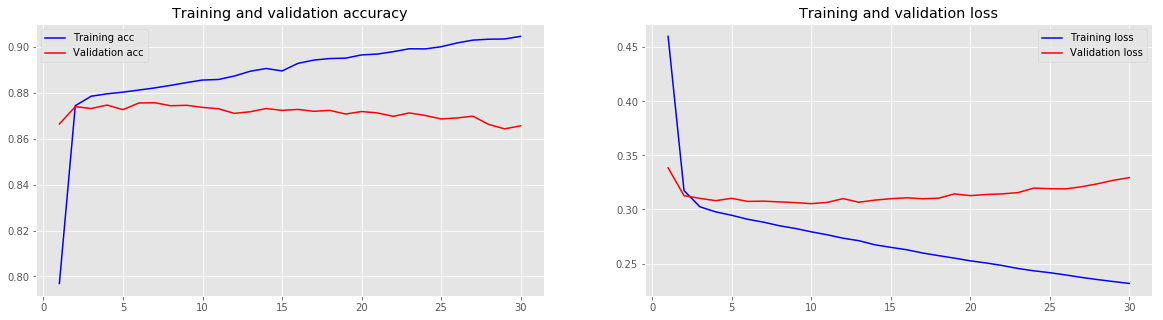

In [0]:
run_nn_model_reduce_size(training_data, validation_data, testing_data, epochs=30)

## NN with Embedding layer

In [0]:
def build_nn_with_embedding(input_dim, output_dim, input_length):
  model = Sequential()
  model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, 
                           input_length=input_length))
  model.add(layers.GlobalAveragePooling1D())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

def run_nn_with_embedding(training_data, validation_data
               , testing_data, embedding_dim=100, epochs=10, batch_size=100):
  print("Tokenizing...")
  tokenizer = get_tokenizer()
  training_tokens = tokenize_sentences(training_data[review_col].values, tokenizer)
  validation_tokens = tokenize_sentences(validation_data[review_col].values, tokenizer)
  testing_tokens = tokenize_sentences(testing_data[review_col].values, tokenizer)
  list_tokens = np.concatenate((training_tokens, validation_tokens, testing_tokens))
  
  print("Building dictionary...")
  dictionary = Dictionary(list_tokens)
  
  print("Transforming review to token index...")
  # Since dictionary start at index 0, I need to add 1, later I want to pad with 0
  X_train = [np.array(dictionary.doc2idx(tokens))+1 for tokens in training_tokens]
  y_train = training_data[label_col].values

  X_val = [np.array(dictionary.doc2idx(tokens))+1 for tokens in validation_tokens]
  y_val = validation_data[label_col].values

  X_test = [np.array(dictionary.doc2idx(tokens))+1 for tokens in testing_tokens]
  y_test = testing_data[label_col].values

  vocab_size = len(dictionary) + 1 # Add 1 for index 0 when padding
  print("Vocabulary size: {}".format(vocab_size))
  max_len = find_max_len_in_matrices(X_train, X_val, X_test)
  print("Max length of review: {}".format(max_len))
  
  X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
  X_val = pad_sequences(X_val, padding='post', maxlen=max_len)
  X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

  print("Building model...")
  model = build_nn_with_embedding(vocab_size, embedding_dim, max_len)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  print(model.summary())

  history = model.fit(X_train, y_train, epochs=epochs
                      , validation_data=(X_val, y_val), batch_size=batch_size)
  plot_history(history)
  print("Evaluation...")
  evaluate_nn(model, X_train, y_train, X_val, y_val, X_test, y_test)

Building dictionary...
Transforming review to token index...
Vocabulary size: 60538
Max length of review: 1149


W0707 16:05:22.789094 139647300614016 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1149, 100)         6053800   
_________________________________________________________________
global_average_pooling1d_3 ( (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 6,060,329
Trainable params: 6,060,329
Non-trainable params: 0
________________________________________________

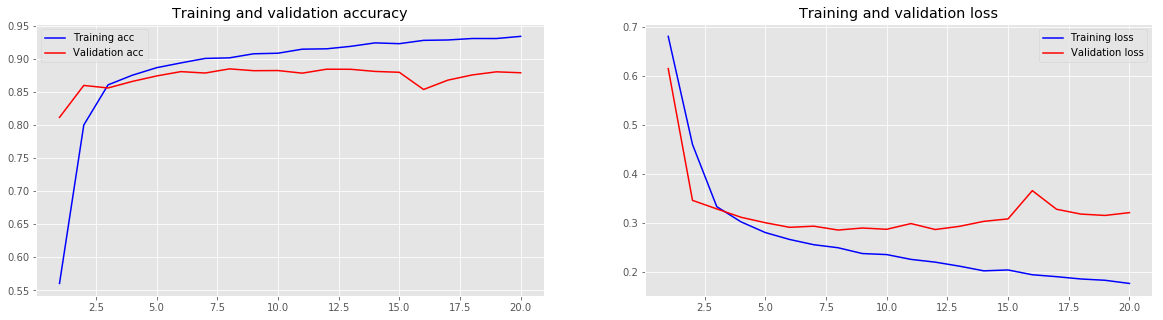

In [0]:
run_nn_with_embedding(training_data, validation_data
               , testing_data, embedding_dim=100, epochs=20, batch_size=64)

## NN with pre-trained embedding

In [0]:
def build_embeding_matrix(word_vectors, vocab_size, vector_dim):
  embedding_matrix = np.zeros((vocab_size, vector_dim))
  for index in range(1, vocab_size):
    # zero-based index
    word = word_vectors.index2word[index-1]
    embedding_matrix[index] = word_vectors[word]
  
  return embedding_matrix

def build_nn_with_pretrained_embedding(weights, input_length, trainable=False):
  print("Trainable: {}".format(trainable))
  model = Sequential()
  input_dim = np.shape(weights)[0]
  output_dim = np.shape(weights)[1]
  model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length
                             , embeddings_initializer=Constant(weights)
                            , trainable=trainable))
  model.add(layers.GlobalAveragePooling1D())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  print(model.summary())
  
  return model

def run_nn_with_pretrained_embedding(training_data, validation_data
               , testing_data, pretrained_file, trainable=False, epochs=10, batch_size=100):
  print("Tokenizing...")
  tokenizer = get_tokenizer()
  training_tokens = tokenize_sentences(training_data[review_col].values, tokenizer)
  validation_tokens = tokenize_sentences(validation_data[review_col].values, tokenizer)
  testing_tokens = tokenize_sentences(testing_data[review_col].values, tokenizer)

  print("Loading word2vec...")
  word_vectors = KeyedVectors.load_word2vec_format(pretrained_file)

  X_train = transform_sentences_to_indices(word_vectors, training_tokens)
  y_train = training_data[label_col].values

  X_val = transform_sentences_to_indices(word_vectors, validation_tokens)
  y_val = validation_data[label_col].values

  X_test = transform_sentences_to_indices(word_vectors, testing_tokens)
  y_test = testing_data[label_col].values

  vocab_size = len(word_vectors.vocab) + 1 # Add 1 for index 0 when padding
  print("Vocabulary size: {}".format(vocab_size))
  max_len = find_max_len_in_matrices(X_train, X_val, X_test)
  print("Max length of review: {}".format(max_len))

  X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
  X_val = pad_sequences(X_val, padding='post', maxlen=max_len)
  X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

  print("Building embedding matrix...")
  vector_dim = len(word_vectors[word_vectors.index2word[0]])
  embedding_matrix = build_embeding_matrix(word_vectors, vocab_size, vector_dim)

  print("Building model...")
  model = build_nn_with_pretrained_embedding(embedding_matrix, max_len, trainable=trainable)
  print("Training model...")
  history = model.fit(X_train, y_train, epochs=epochs
                      , validation_data=(X_val, y_val), batch_size=batch_size)
  plot_history(history)
  print("Evaluation...")
  evaluate_nn(model, X_train, y_train, X_val, y_val, X_test, y_test)

Loading word2vec...


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Vocabulary size: 170104
Max length of review: 1149
Building embedding matrix...
Building model...
Trainable: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1149, 100)         17010400  
_________________________________________________________________
global_average_pooling1d_10  (None, 100)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 17,016,929
Tra

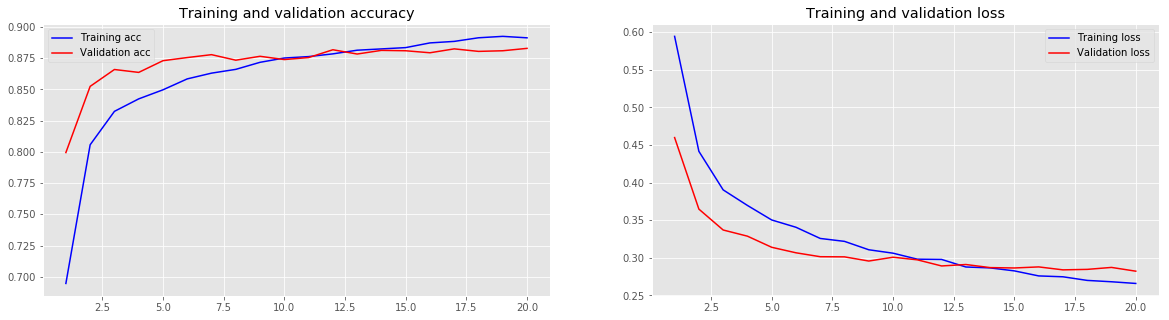

In [0]:
# use pre-trained embedding from unlabeled dataset
run_nn_with_pretrained_embedding(training_data, validation_data, testing_data
                                 , unlabeled_w2v_file, trainable=True, epochs=20, batch_size=64)

Loading word2vec...


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Vocabulary size: 60538
Max length of review: 1149
Building embedding matrix...
Building model...
Trainable: False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1149, 100)         6053800   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 6,060,329
Trai

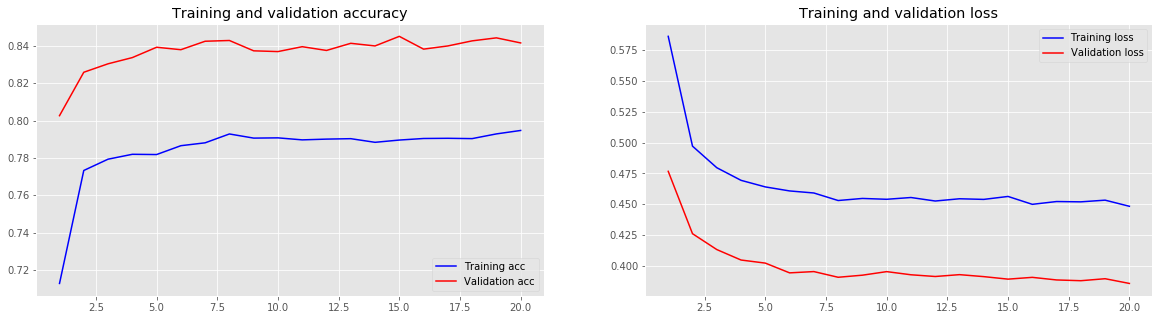

In [0]:
# use pre-trained embedding from labeled dataset
run_nn_with_pretrained_embedding(training_data, validation_data, testing_data
                                 , w2v_file, trainable=False, epochs=20, batch_size=64)

## LSTM

In [0]:
def build_LSTM_with_pretrained_embedding(weights, input_length, trainable=False):
  print("Trainable: {}".format(trainable))
  model = Sequential()
  input_dim = np.shape(weights)[0]
  output_dim = np.shape(weights)[1]
  
  model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length
                             , embeddings_initializer=Constant(weights)
                            , trainable=trainable))
  model.add(layers.CuDNNLSTM(64, return_sequences=True))
  model.add(layers.AveragePooling1D(input_length))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  print(model.summary())
  
  return model

def build_BiLSTM_with_pretrained_embedding(weights, input_length, trainable=False):
  print("Trainable: {}".format(trainable))
  model = Sequential()
  input_dim = np.shape(weights)[0]
  output_dim = np.shape(weights)[1]
  
  model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length
                             , embeddings_initializer=Constant(weights)
                            , trainable=trainable))
  model.add(layers.Bidirectional(layers.CuDNNLSTM(64, return_sequences=True)))
  model.add(layers.AveragePooling1D(input_length))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  print(model.summary())
  
  return model

def run_lstm_pretrained_embedding(training_data, validation_data
               , testing_data, pretrained_file, trainable=False, epochs=10, batch_size=100):
  print("Tokenizing...")
  tokenizer = get_tokenizer()
  training_tokens = tokenize_sentences(training_data[review_col].values, tokenizer)
  validation_tokens = tokenize_sentences(validation_data[review_col].values, tokenizer)
  testing_tokens = tokenize_sentences(testing_data[review_col].values, tokenizer)

  print("Loading word2vec...")
  word_vectors = KeyedVectors.load_word2vec_format(pretrained_file)

  X_train = transform_sentences_to_indices(word_vectors, training_tokens)
  y_train = training_data[label_col].values

  X_val = transform_sentences_to_indices(word_vectors, validation_tokens)
  y_val = validation_data[label_col].values

  X_test = transform_sentences_to_indices(word_vectors, testing_tokens)
  y_test = testing_data[label_col].values

  vocab_size = len(word_vectors.vocab) + 1 # Add 1 for index 0 when padding
  print("Vocabulary size: {}".format(vocab_size))
  max_len = find_max_len_in_matrices(X_train, X_val, X_test)
  print("Max length of review: {}".format(max_len))

  X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
  X_val = pad_sequences(X_val, padding='post', maxlen=max_len)
  X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

  vector_dim = len(word_vectors[word_vectors.index2word[0]])
  print("Building embedding matrix...")
  embedding_matrix = build_embeding_matrix(word_vectors, vocab_size, vector_dim)

  print("Building model...")
  model = build_LSTM_with_pretrained_embedding(embedding_matrix, max_len, trainable=trainable)
  
  print("Training model...")
  history = model.fit(X_train, y_train, epochs=epochs
                      , validation_data=(X_val, y_val), batch_size=batch_size)
  plot_history(history)
  print("Evaluation...")
  evaluate_nn(model, X_train, y_train, X_val, y_val, X_test, y_test)
  
def run_bilstm_pretrained_embedding(training_data, validation_data
               , testing_data, pretrained_file, trainable=False, epochs=10, batch_size=100):
  print("Tokenizing...")
  tokenizer = get_tokenizer()
  training_tokens = tokenize_sentences(training_data[review_col].values, tokenizer)
  validation_tokens = tokenize_sentences(validation_data[review_col].values, tokenizer)
  testing_tokens = tokenize_sentences(testing_data[review_col].values, tokenizer)

  print("Loading word2vec...")
  word_vectors = KeyedVectors.load_word2vec_format(pretrained_file)

  X_train = transform_sentences_to_indices(word_vectors, training_tokens)
  y_train = training_data[label_col].values

  X_val = transform_sentences_to_indices(word_vectors, validation_tokens)
  y_val = validation_data[label_col].values

  X_test = transform_sentences_to_indices(word_vectors, testing_tokens)
  y_test = testing_data[label_col].values

  vocab_size = len(word_vectors.vocab) + 1 # Add 1 for index 0 when padding
  print("Vocabulary size: {}".format(vocab_size))
  max_len = find_max_len_in_matrices(X_train, X_val, X_test)
  print("Max length of review: {}".format(max_len))

  X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
  X_val = pad_sequences(X_val, padding='post', maxlen=max_len)
  X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

  vector_dim = len(word_vectors[word_vectors.index2word[0]])
  print("Building embedding matrix...")
  embedding_matrix = build_embeding_matrix(word_vectors, vocab_size, vector_dim)

  print("Building model...")
  model = build_BiLSTM_with_pretrained_embedding(embedding_matrix, max_len, trainable=trainable)
  
  print("Training model...")
  history = model.fit(X_train, y_train, epochs=epochs
                      , validation_data=(X_val, y_val), batch_size=batch_size)
  plot_history(history)
  print("Evaluation...")
  evaluate_nn(model, X_train, y_train, X_val, y_val, X_test, y_test)

In [0]:
run_lstm_pretrained_embedding(training_data, validation_data, testing_data
                                           , pretrained_file=w2v_file, epochs=20, batch_size=64, trainable=True)

In [0]:
run_lstm_pretrained_embedding(training_data, validation_data, testing_data
                             , pretrained_file=unlabeled_w2v_file, epochs=20, batch_size=64, trainable=True)

In [0]:
run_bilstm_pretrained_embedding(training_data, validation_data, testing_data
                              , pretrained_file=w2v_10000_file, epochs=20, batch_size=64, trainable=True)

# Final step

## Combine aspect and sentiment analysis

In [0]:
from gensim.models import LdaModel
from keras.models import load_model
from datetime import datetime

In [0]:
unlabeled_data_file = "/content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dang/lda/cleaned_data.pkl"
lda_model_file = "/content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dang/lda/6_topics/lda_model"
dict_file = "/content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dang/lda/dict.txt"
sentiment_model_file = "/content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dang/best_model.h5"
final_result_file = "/content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dang/final_result.pkl"

result_col = "result"
tokens_col = "tokens"
topic_key = "topic"
sentiment_key = "sentiment"
brand_id_col = "brand_link"
brand_name_col = "brand_name"

topic_mapping = {
    0: "Thức uống",
    1: "Món ăn",
    2: "Phục vụ",
    3: "Không gian",
    4: "???",
    5: "Giá - chất lượng"
}

sentiment_mapping = {
    0: "Negative",
    1: "Possitive"
}

def read_unlabeled_data():
  return pd.read_pickle(unlabeled_data_file)

def load_dict():
  return Dictionary.load_from_text(dict_file)
  
def load_lda_model():
  return LdaModel.load(lda_model_file)

def load_sentiment_model():
  return load_model(sentiment_model_file)

def rank_topic(tuples):
  return sorted(tuples, key=lambda t: t[1], reverse = True)[0][0]

def get_sentiment_id(score):
  if score > 0.5:
    # Positive
    return 1
  return 0

def predict_topic(tokens, lda_model, dictionary):
  topic_dist = lda_model.get_document_topics(dictionary.doc2bow(tokens))
  topic_id = rank_topic(topic_dist)
  return topic_id

def predict_sentiment(tokens, sentiment_model, word_vectors):
  X_new = [transform_tokens_to_indices(word_vectors, tokens)]
  X_new = pad_sequences(X_new, padding='post', maxlen=1149)
  y_new = sentiment_model.predict(X_new)
  sentiment_id = get_sentiment_id(y_new[0][0])
  return sentiment_id

def analyze_aspect_sentiment(list_tokens, lda_model, dictionary
                              , sentiment_model, word_vectors):
  tuples = []
  for tokens in list_tokens:
    topic_id = predict_topic(tokens, lda_model, dictionary)
    sentiment_id = predict_sentiment(tokens, sentiment_model, word_vectors)
#     print("Topic: {}, Sentiment: {}".format(topic_mapping.get(topic_id), sentiment_mapping.get(sentiment_id)))
    tpl = {topic_key: topic_id, sentiment_key: sentiment_id}
    tuples.append(tpl)
  return tuples

def run_analyzer(start, stop, saved_file):
  print("Running aspect-based sentiment analyzer from review {} to review {}..."
       .format(start, stop))
  now = datetime.now()
  df = unlabeled_data.loc[range(start, stop)]
  df[result_col] = df[tokens_col].apply(analyze_aspect_sentiment
                  , args=(lda_model, dictionary, sentiment_model, word_vectors,))
  
  print("Saving file at: {}".format(saved_file))
  df.to_pickle(saved_file)
  
  then = datetime.now()
  print("Finish!")
  print("Take: {}".format(then-now))
  
def run_analyzer_for_reviews(df, saved_file):
  now = datetime.now()
  df[result_col] = df[tokens_col].apply(analyze_aspect_sentiment
                  , args=(lda_model, dictionary, sentiment_model, word_vectors,))
  
  print("Saving file at: {}".format(saved_file))
  df.to_pickle(saved_file)
  
  then = datetime.now()
  print("Finish!")
  print("Take: {}".format(then-now))
  
def is_hcm_shop(brand_link):
  return "ho-chi-minh" in brand_link
  
def select_top_reviewed_brands(n_brands):
  review_by_brand = unlabeled_data.groupby(brand_id_col).count()[brand_name_col].sort_values(ascending=False)
  
  top_brands = []
  total_reviews = 0
  n_remaining_brands = n_brands
  i = 0
  
  while n_remaining_brands > 0:
    brand_link = review_by_brand.index[i]
    if is_hcm_shop(brand_link) == True:
      top_brands.append(brand_link)
      total_reviews += review_by_brand[i]
      n_remaining_brands -= 1
    i += 1
  print("Total reviews: {}".format(total_reviews))
  return top_brands

def review_by_brand_statistic():
  review_by_brand = unlabeled_data.groupby(brand_id_col).count()[brand_name_col].values
  print("Minimum reviews per brand: {} \nMaximum reviews per brand: {} \nAverage: {}"
      .format(min(review_by_brand), max(review_by_brand), np.mean(review_by_brand)))
  
def filter_top_brands(brand_id, top_brands):
  return brand_id in top_brands

def filter_reviews_in_top_reviewed_brands(n_brands):
  top_brands = select_top_reviewed_brands(n_brands)
  return unlabeled_data.loc[unlabeled_data[brand_id_col].apply(filter_top_brands, args=(top_brands,))]

In [0]:
unlabeled_data = read_unlabeled_data()
# dictionary = load_dict()
# lda_model = load_lda_model()
# word_vectors = KeyedVectors.load_word2vec_format(unlabeled_w2v_file)
# sentiment_model = load_sentiment_model()

In [0]:
# start = 15000
# stop = 20000
# result_file_template = "/content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dang/result_{0}_{1}.pkl"
# result_file = result_file_template.replace("{0}", str(start)).replace("{1}", str(stop))
# run_analyzer(start, stop, result_file)

Running aspect-based sentiment analyzer from review 15000 to review 20000...
Saving file at: /content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dang/result_15000_20000.pkl
Finish!
Take: 0:11:39.891661


In [0]:
review_by_brand_statistic()

Minimum reviews per brand: 1 
Maximum reviews per brand: 445 
Average: 11.846175597342004


In [0]:
n_brands = 10
top_reviewed_result_file_template = "/content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dang/top_{0}_reviewed_brand.pkl"
top_reviewed_result_file = top_reviewed_result_file_template.replace("{0}", str(n_brands))

top_reviewed_brands = filter_reviews_in_top_reviewed_brands(n_brands)
run_analyzer_for_reviews(top_reviewed_brands, top_reviewed_result_file)

Total reviews: 4154
Saving file at: /content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dang/top_10_reviewed_brand.pkl
Finish!
Take: 0:09:22.784347


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Statistic

In [0]:
from collections import Counter

In [0]:
def analyze_brand(df, brand_link):
  list_tuples = df.loc[review_result[brand_id_col] == brand_link, result_col].values
  topics = []
  sentiments = []
  for tuples in list_tuples:
    for t in tuples:
      topics.append(t.get(topic_key))
      sentiments.append("{}_{}".format(t.get(topic_key), t.get(sentiment_key)))
  topic_counter = Counter(topics)
  sentiment_counter = Counter(sentiments)
  
  most_common_topic = topic_counter.most_common(1)[0][0]
  most_common_topic_count = topic_counter.most_common(1)[0][1]
  total_topic_count = sum(topic_counter.values())
  topic_percentage = most_common_topic_count / total_topic_count * 100
#   print("Most common topic: {}, take: {}%".format(most_common_topic, topic_percentage))
  
  sentiment_counter_dict = dict(sentiment_counter)
  pos_key = "{}_{}".format(str(most_common_topic), 1)
  neg_key = "{}_{}".format(str(most_common_topic), 0)
  
  pos_count = sentiment_counter_dict.get(pos_key)
  neg_count = sentiment_counter_dict.get(neg_key)
  sentiment_count = pos_count + neg_count
  post_percentage = pos_count/sentiment_count*100
  neg_percentage = neg_count/sentiment_count*100
#   print("Positive: {}, take: {}%, Negative: {}, take: {}%".format(pos_count, pos_count/sentiment_count*100, neg_count, neg_count/sentiment_count*100))
  return most_common_topic, topic_percentage, post_percentage, neg_percentage

def analyze_review(review_result):
  df = pd.DataFrame(columns=[brand_name_col, most_common_topic_col
                           , common_topic_percentage_col, common_topic_pos_col, common_topic_neg_col])
  brand_links = review_result[brand_id_col].unique()
  for brand_link in brand_links:
    brand_name = review_result.loc[review_result[brand_id_col] == brand_link, brand_name_col].values[0]
    most_common_topic, topic_percentage, post_percentage, neg_percentage = analyze_brand(review_result, brand_link)
    
    df = df.append({brand_name_col: brand_name
               , most_common_topic_col: topic_mapping.get(most_common_topic)
              , common_topic_percentage_col: round(topic_percentage,2)
              , common_topic_pos_col: round(post_percentage, 2)
              , common_topic_neg_col: round(neg_percentage, 2)}
             , ignore_index=True)
  return df

def analyze_detail_in_brand(df, brand_link, n_sentences):
  count = 0
  filer_df = df.loc[review_result[brand_id_col] == brand_link]
  brand_name = filer_df[brand_name_col].values[0]
  print("Shop: {}".format(brand_name))
  for i, row in filer_df.iterrows():
    sentences = row[sentences_col]
    tuples = row[result_col]
    
    for j in range(0, len(sentences)):
      print("\nSentence: {}".format(sentences[j]))
      topic = topic_mapping.get(tuples[j].get(topic_key))
      sentiment = sentiment_mapping.get(tuples[j].get(sentiment_key))
      print("Topic: {}, Sentiment: {}".format(topic, sentiment))
      count += 1
    if count > n_sentences:
      break
  

In [0]:
review_result_file = "/content/drive/My Drive/Master/2nd Semester/AdvMLDM/Project_AdvMLDM/dang/top_10_reviewed_brand.pkl"
brand_name_col = "brand_name"
most_common_topic_col = "most_common_topic"
sentences_col = "sentences"
common_topic_percentage_col = "common_topic_percentage"
common_topic_pos_col = "common_topic_pos_percentage"
common_topic_neg_col = "common_topic_neg_percentage"

In [0]:
review_result = pd.read_pickle(review_result_file)
analyze_review(review_result)

,brand_name,most_common_topic,common_topic_percentage,common_topic_pos_percentage,common_topic_neg_percentage
0,Hanuri - Quán Ăn Hàn Quốc - Sư Vạn Hạnh,???,24.44,34.59,65.41
1,Mì Ý Double B,Món ăn,28.44,49.54,50.46
2,Hebe - Tea & Coffee,Thức uống,42.66,40.51,59.49
3,IZZIBING Snow Dessert Coffee - Bingsu,Thức uống,31.55,56.22,43.78
4,Koi Thé Café - Ngô Đức Kế,Thức uống,39.99,46.99,53.01
5,Papa's Chicken - Phú Mỹ Hưng,Món ăn,37.64,42.96,57.04
6,Phúc Long Coffee & Tea House - Lý Tự Trọng,Thức uống,34.17,47.51,52.49
7,Texas Chicken - Phan Xích Long,Món ăn,28.08,53.39,46.61
8,Trà Sữa R&B Tea - Ngô Đức Kế,Thức uống,47.21,36.16,63.84
9,Xôi Chè Bùi Thị Xuân - Bùi Thị Xuân,Món ăn,26.24,36.93,63.07


In [0]:
select_top_reviewed_brands(10)

Total reviews: 4154


['https://www.foody.vn/ho-chi-minh/koi-the-cafe-viet-nam-ngo-duc-ke',
 'https://www.foody.vn/ho-chi-minh/hanuri-quan-an-han-quoc',
 'https://www.foody.vn/ho-chi-minh/phuc-long-coffee-tea-house-ly-tu-trong',
 'https://www.foody.vn/ho-chi-minh/xoi-che-bui-thi-xuan-bui-thi-xuan',
 'https://www.foody.vn/ho-chi-minh/mi-y-double-b',
 'https://www.foody.vn/ho-chi-minh/tra-sua-r-b-tea-ngo-duc-ke',
 'https://www.foody.vn/ho-chi-minh/texas-chicken-phan-xich-long',
 'https://www.foody.vn/ho-chi-minh/hebe-tea-and-coffee',
 'https://www.foody.vn/ho-chi-minh/papa-s-chicken',
 'https://www.foody.vn/ho-chi-minh/izzibing-pho-quang']

In [0]:
n_sentences = 10
brand_link = "https://www.foody.vn/ho-chi-minh/phuc-long-coffee-tea-house-ly-tu-trong"
analyze_detail_in_brand(review_result, brand_link, n_sentences)

Shop: Phúc Long Coffee & Tea House - Lý Tự Trọng

Sentence: không có gì đặc biệtmình chẳng hiểu sao nhiều bạn lại ghiền phúc long đến thế chứ riêng mình thì không thấy có gì đặc sắc ở loại trà này cả chắc có lẽ chọn chưa đúng món ngon nhưng khuyến cáo mấy bạn đừng nên gọi món phúc long cocktail tea không ngon mà còn phải chờ lâu kinh khủng
Topic: Thức uống, Sentiment: Negative

Sentence: best ❤trà sữa phúc long ngon cực
Topic: Thức uống, Sentiment: Possitive

Sentence: trà xanh đá xay thì toẹt vời hơn
Topic: Thức uống, Sentiment: Possitive

Sentence: cream ngon ngon béo béo
Topic: Thức uống, Sentiment: Possitive

Sentence: nhất định sẽ quay lạiiiii ❤❤❤
Topic: Phục vụ, Sentiment: Possitive

Sentence: phúc long coffee & tea house  lý tự trọngnay thèm phúc long tiện đi ngang qua đây mình ghé vào mua uống
Topic: ???, Sentiment: Negative

Sentence: mình order trà đào vẫn như cũ k  miếng đào thì phải nhưng khi hút được  ngụm cảm giác thật là
Topic: Thức uống, Sentiment: Negative

Sentence: w